# Testing PMT with chamber windows blocked

- Hamamatsu R375 PMT
- SRS445A amplifier @125x amplification & @500 Ohm input impedance
- SRS HV PSU @1300 V
- 5 MHz low pass filter before the last amplification channel.
- NI PXIe-5171 Oscilloscope

Lights are at lowest brightness setting.

In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks
from scipy.integrate import simps

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
data_loc = "D:/PMT Single Photons/2018_12_21/"
fname = "single_photons.hdf5"

In [3]:
%%time
data = np.empty([805306192,1], dtype = np.int16)

with h5py.File(data_loc+fname, 'r') as f:
    attrs = dict(f['waveforms/record_0'].attrs.items())
    data = f['waveforms/record_0'].value

Wall time: 8.96 s


In [4]:
attrs

{'gain': 9.465828952670563e-05,
 'offset': -0.0006035383557900786,
 'x_increment': 4e-09,
 'absolute_initial_x': 596206.54055328}

In [5]:
gain = attrs['gain']
offset = attrs['offset']

In [6]:
%%time
peakLocs, peakInfo = find_peaks(np.abs(data), height = 120, distance = 800, width = 10)
print(len(peakLocs))

147403


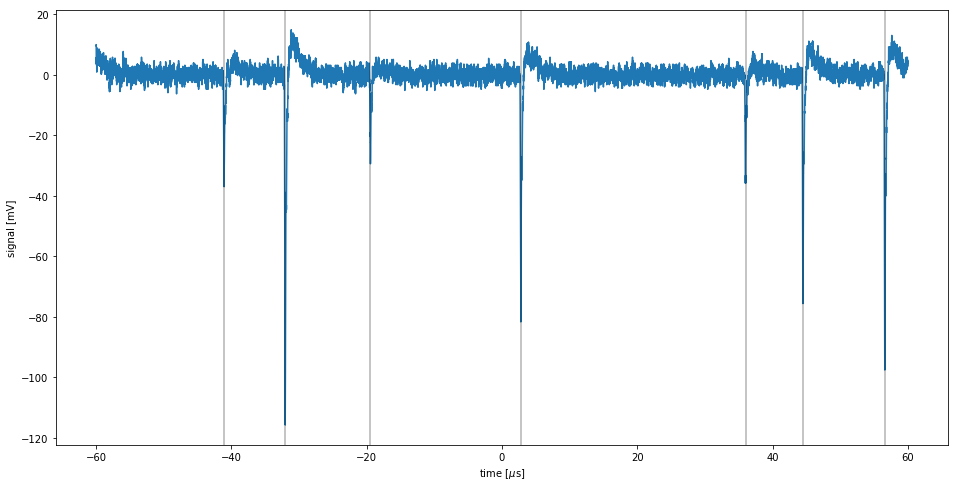

In [7]:
start, stop = 20000, 50000
peaks = peakLocs[(peakLocs >= start) & (peakLocs < stop)]
y = (data[start:stop]*gain+offset)*1e3
x = np.linspace(-len(y)//2,len(y)//2-1,len(y))*attrs['x_increment']*1e6

fig, ax = plt.subplots(figsize = (16,8))
ax.plot(x,y)
[ax.axvline((p*4e-9-(start+stop)/2*4e-9)*1e6, color = 'black', alpha = 0.3) for p in peaks]
ax.set_xlabel('time [$\mu$s]')
ax.set_ylabel('signal [mV]');

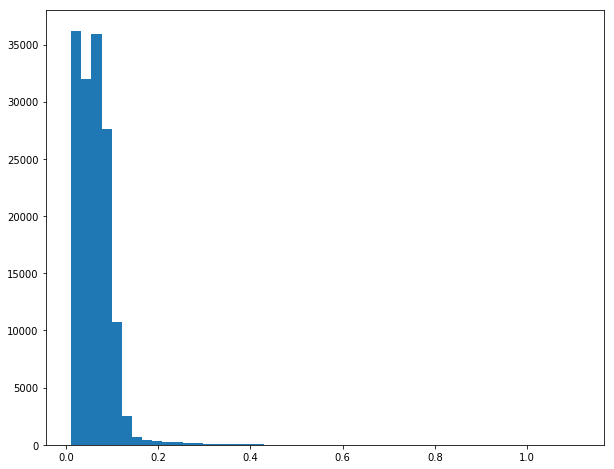

In [8]:
fig, ax = plt.subplots(figsize = (10,8))
ax.hist(peakInfo['peak_heights']*gain+offset, bins = 50);

In [9]:
from tqdm import tqdm

fname = "single_photons.hdf5"
peakHeights = []

with h5py.File(data_loc+fname, 'r') as f:
    for dset in tqdm(f['waveforms/']):
        data = np.empty([805306192,1], dtype = np.int16)
        attrs = dict(f['waveforms/record_0'].attrs.items())
        data = f['waveforms/'+dset].value
        peakLocs, peakInfo = find_peaks(np.abs(data), height = 120, distance = 800, width = 20)
        peakHeights.append(peakInfo['peak_heights']*attrs['gain']+attrs['offset'])
    peakHeights = np.concatenate(peakHeights).ravel()

100%|██████████| 10/10 [10:37<00:00, 63.70s/it]


In [10]:
peakheights_on = peakHeights.copy()

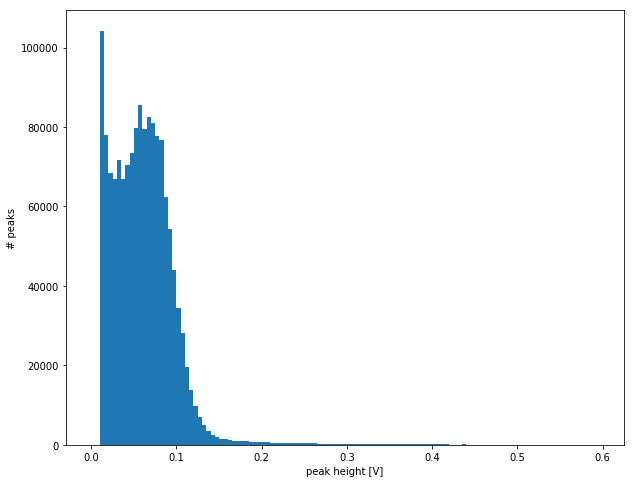

In [11]:
bins = np.arange(0,0.6,5e-3)
fig, ax = plt.subplots(figsize = (10,8))
ax.hist(peakheights_on, bins = bins);
ax.set_xlabel('peak height [V]')
ax.set_ylabel('# peaks');

## Lights off

In [12]:
fname = 'single_photons_lightsoff.hdf5'
from tqdm import tqdm

peakHeights = []

with h5py.File(data_loc+fname, 'r') as f:
    for dset in tqdm(f['waveforms/']):
        data = np.empty([805306192,1], dtype = np.int16)
        attrs = dict(f['waveforms/record_0'].attrs.items())
        data = f['waveforms/'+dset].value
        peakLocs, peakInfo = find_peaks(np.abs(data), height = 120, distance = 800, width = 20)
        peakHeights.append(peakInfo['peak_heights']*attrs['gain']+attrs['offset'])
    peakHeights = np.concatenate(peakHeights).ravel()

100%|██████████| 10/10 [10:15<00:00, 61.55s/it]


In [13]:
peakheights_off = peakHeights.copy()

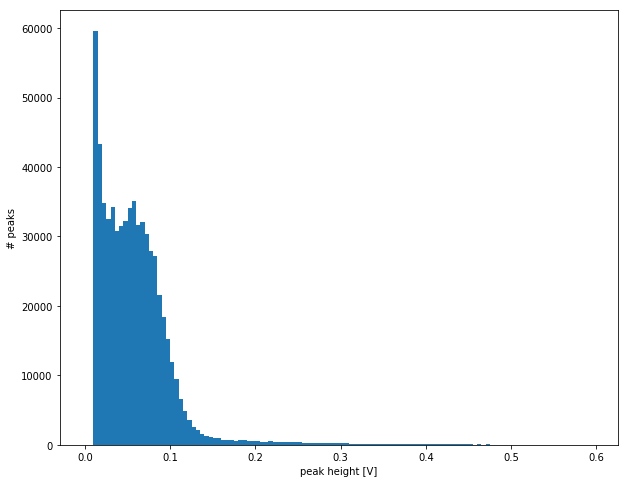

In [14]:
bins = np.arange(0,0.6,5e-3)
fig, ax = plt.subplots(figsize = (10,8))
ax.hist(peakheights_off, bins = bins);
ax.set_xlabel('peak height [V]')
ax.set_ylabel('# peaks');

## Comparison

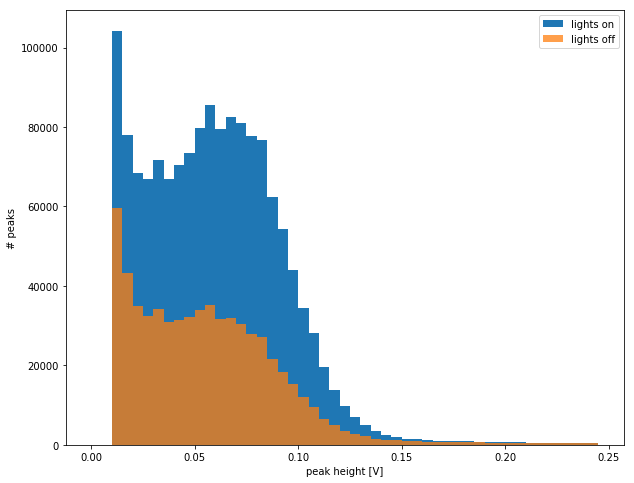

In [15]:
bins = np.arange(0,0.25, 5e-3)
fig, ax = plt.subplots(figsize = (10,8))
hist_on = ax.hist(peakheights_on, bins = bins, label = 'lights on');
hist_off = ax.hist(peakheights_off, bins = bins, alpha = 0.75, label = 'lights off');
ax.set_xlabel('peak height [V]')
ax.set_ylabel('# peaks');
ax.legend();

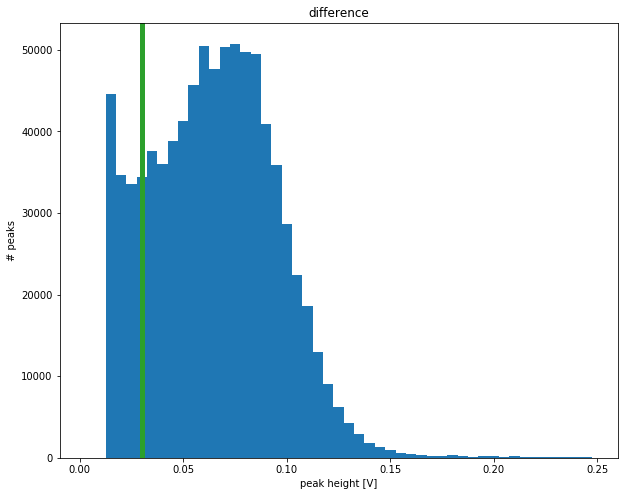

In [16]:
xx, yy = np.diff(hist_on[1])+hist_on[1][:-1], hist_on[0]-hist_off[0]

fig, ax = plt.subplots(figsize = (10,8))
ax.bar(xx,yy, width = np.diff(xx)[0])
ax.set_xlabel('peak height [V]')
ax.set_ylabel('# peaks');
ax.set_title('difference')
ax.axvline(0.03, color = 'C2', lw = 5)

mean : 68.51 mV


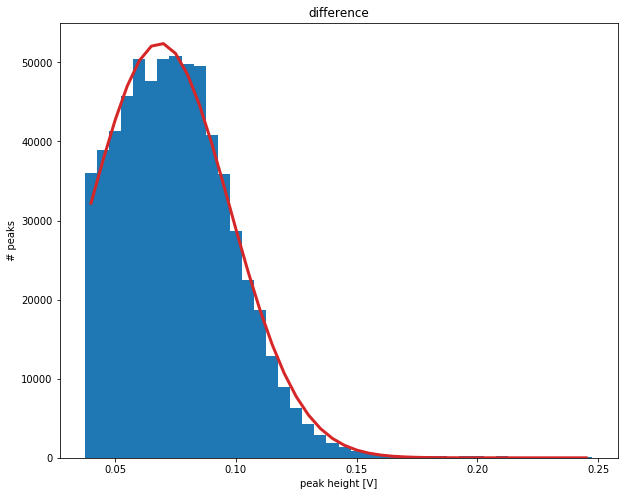

In [17]:
from scipy.optimize import curve_fit

def gaussian(x, amp, mu, sig):
    return amp*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

xx, yy = np.diff(hist_on[1])+hist_on[1][:-1], hist_on[0]-hist_off[0]
mask = xx > 0.035
xx = xx[mask]
yy = yy[mask]

fig, ax = plt.subplots(figsize = (10,8))
ax.bar(xx,yy, width = np.diff(xx)[0])
ax.set_xlabel('peak height [V]')
ax.set_ylabel('# peaks');
ax.set_title('difference')

popt, pcov = curve_fit(gaussian, xx, yy)
print('mean : {:.2f} mV'.format(popt[1]*1e3))

ax.plot(xx, gaussian(xx, *popt), 'C3', lw = 3);

## Determining FWHM of single photon peaks

In [18]:
from scipy.interpolate import interp1d
from scipy.optimize import brentq
from tqdm import tqdm_notebook as tqdm

fname = 'single_photons.hdf5'

show_errors = False

peakWidths = []
width = 500
xx = np.linspace(-width,width-1,2*width)*4e-9*1e6

with h5py.File(data_loc+fname, 'r') as f:
    for dset in tqdm(f['waveforms/']):
        data = np.empty([805306192,1], dtype = np.int16)
        attrs = dict(f['waveforms/record_0'].attrs.items())
        data = f['waveforms/'+dset].value
        peakLocs, peakInfo = find_peaks(np.abs(data), height = 120, distance = 800, width = 20)
        for peakID, peakLoc in enumerate(tqdm(peakLocs, desc = dset)):
            start, stop = peakLoc-width, peakLoc+width
            yy = data[start:stop]
            try:
                intp = interp1d(xx,yy)
            except Exception as e:
                continue
            half_max = lambda x: yy.min()/2
            intersect = lambda x: intp(x)-half_max(x)
            try:
                left = brentq(intersect, xx.min(), 0)
            except Exception as e:
                if show_errors:
                    print(peakLoc)
                    print(peakInfo['peak_heights'][peakID])
                    fig, ax = plt.subplots(figsize = (12,8))
                    ax.plot(xx, intp(xx))
                    ax.plot(xx, half_max(xx)*np.ones(len(xx)))
                    raise e
                else: 
                    continue
            try:
                right = brentq(intersect, 0, xx.max())
            except Exception as e:
                if show_errors:
                    print('peak location : {0}'.format(peakLoc))
                    print('peak height : {0}'.format(peakInfo['peak_heights'][peakID]))
                    fig, ax = plt.subplots(figsize = (12,8))
                    ax.plot(xx, intp(xx))
                    ax.plot(xx, half_max(xx)*np.ones(len(xx)))
                    raise e
                else:
                    continue
            peakWidths.append(right-left)
    peakWidths = np.array(peakWidths)

gaussian mean : 1.36e-01 us
standard mean : 1.33e-01 us


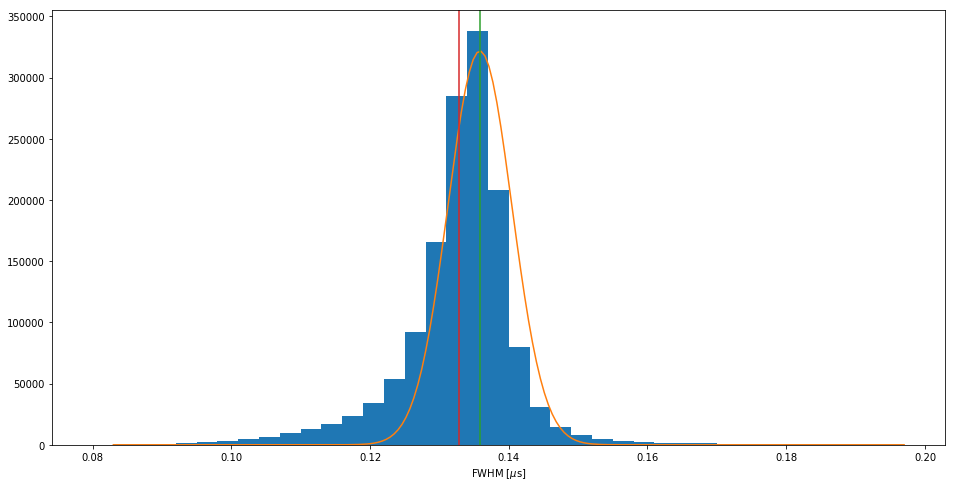

In [19]:
bins = np.arange(0.08,0.2,3e-3)

fig, ax = plt.subplots(figsize = (16,8))
hist = ax.hist(peakWidths, bins = bins);
ax.set_xlabel('FWHM [$\mu$s]')

xx = np.diff(hist[1])+hist[1][:-1]
yy = hist[0]
popt, pcov = curve_fit(gaussian, xx, yy, p0 = (30000, 0.14, 0.02))
xxx = np.linspace(xx.min(), xx.max(), 201)
ax.plot(xxx, gaussian(xxx, *popt))

ax.axvline(popt[1], color = 'C2')
ax.axvline(peakWidths[peakWidths < 0.175].mean(), color = 'C3')

print('gaussian mean : {0:.2e} us'.format(popt[1]))
print('standard mean : {0:.2e} us'.format(peakWidths[peakWidths < 0.175].mean()))

## Calculating PMT gain

In [20]:
import pint

In [21]:
ureg = pint.UnitRegistry()

peak = 68.5*1e-3 * ureg.volt
elementary_charge = 1.6021766*1e-19 * ureg.coulomb
pmt_pulse = 10e-9 * ureg.second
load = 500 * ureg.ohm
amplifier_gain = 125
lowpass_pulse = 0.133*1e-6 * ureg.second


pmt_gain = (peak / ((elementary_charge/pmt_pulse)*load*amplifier_gain*(pmt_pulse/lowpass_pulse))).to_root_units()
print('PMT gain : {0:.2e}'.format(pmt_gain))

PMT gain : 9.10e+05 dimensionless


In [22]:
pmt_pulse = np.arange(5e-9, 20e-9, 0.1e-9) * ureg.second
amp_stage1 = (elementary_charge * pmt_gain.magnitude/(pmt_pulse) * load * 5 ).to(ureg.volt)
amp_stage2 = amp_stage1*5
amp_stage3 = amp_stage2*5

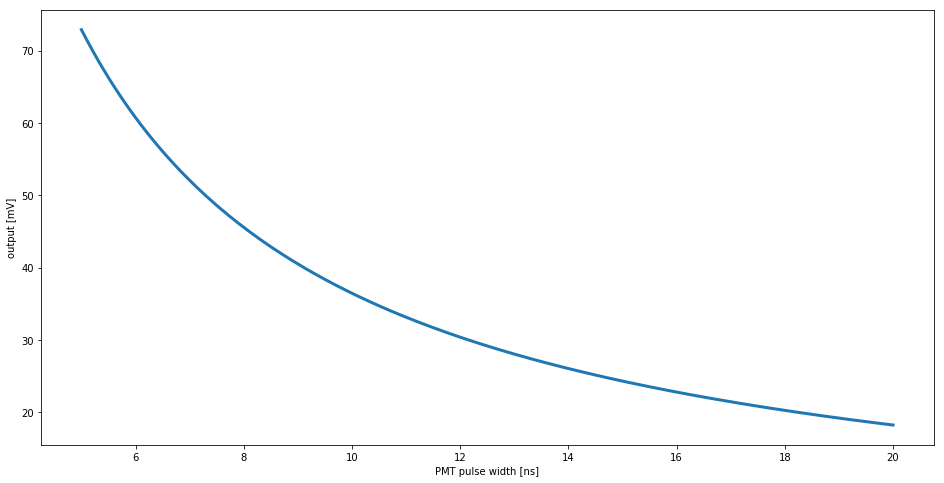

In [23]:
fig, ax = plt.subplots(figsize = (16,8))
ax.plot(pmt_pulse*1e9, amp_stage1*1e3, lw = 3)
ax.set_xlabel('PMT pulse width [ns]');
ax.set_ylabel('output [mV]');

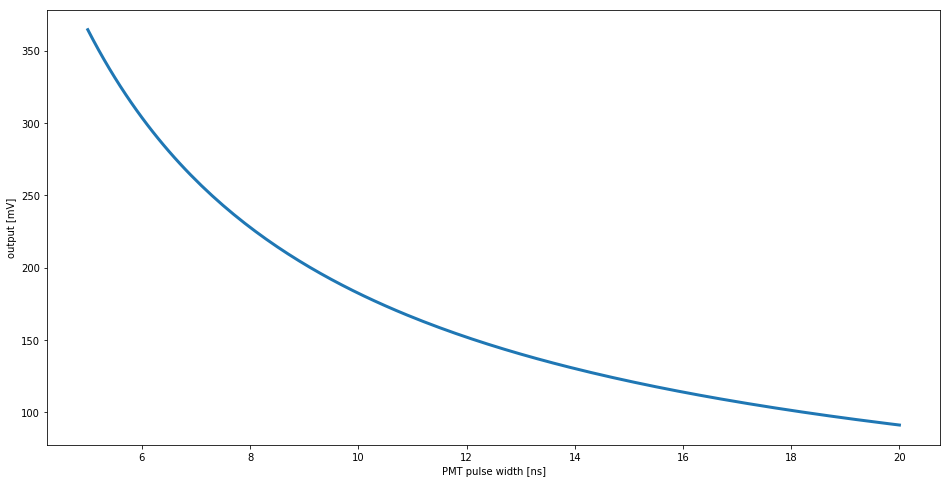

In [24]:
fig, ax = plt.subplots(figsize = (16,8))
ax.plot(pmt_pulse*1e9, amp_stage2*1e3, lw = 3)
ax.set_xlabel('PMT pulse width [ns]');
ax.set_ylabel('output [mV]');

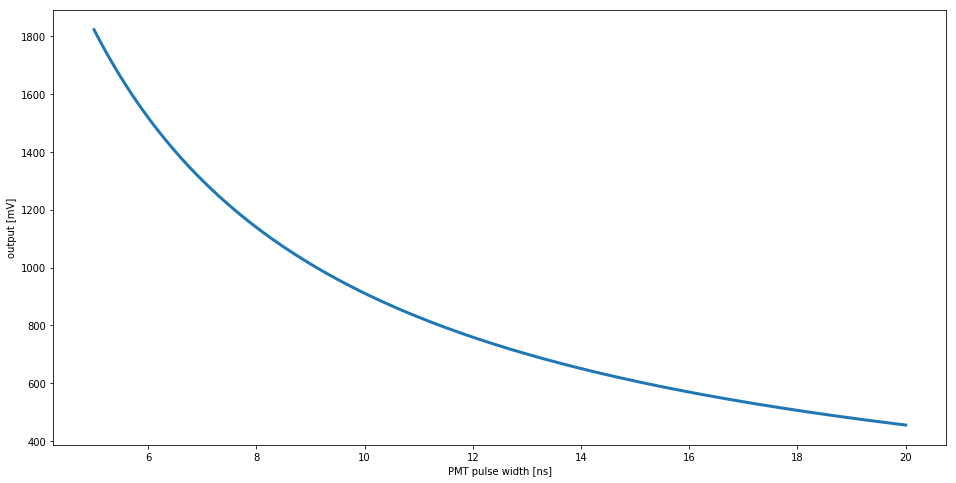

In [25]:
fig, ax = plt.subplots(figsize = (16,8))
ax.plot(pmt_pulse*1e9, amp_stage3*1e3, lw = 3)
ax.set_xlabel('PMT pulse width [ns]');
ax.set_ylabel('output [mV]');

## Checking 500 Ohm vs 50 Ohm
Only using first stage of SRS SR445A reamplifier.

## 500 Ohm preamp input, SR445A@5x, PMT @1300V

In [26]:
%%time

fname = 'single_photons_lightson_500Ohm_ampstage1.hdf5' 

data = np.empty([805306192,1], dtype = np.int16)

with h5py.File(data_loc+fname, 'r') as f:
    attrs = dict(f['waveforms/record_0'].attrs.items())
    data = f['waveforms/record_0'].value

Wall time: 8.66 s


In [27]:
peakLocs, peakInfo = find_peaks(-data, height = 55, distance = 200, width = 1)
print(len(peakLocs))

129797


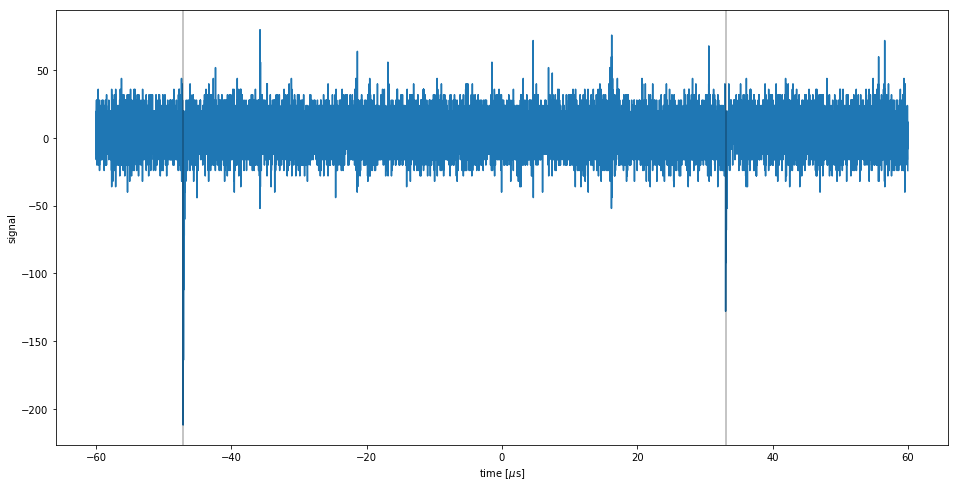

In [28]:
start, stop = 0, 30000
y = data[start:stop]
x = np.linspace(-len(y)//2,len(y)//2-1,len(y))*attrs['x_increment']*1e6
peaks = peakLocs[(peakLocs >= start) & (peakLocs < stop)]


fig, ax = plt.subplots(figsize = (16,8))
ax.plot(x,y)
ax.set_xlabel('time [$\mu$s]')
ax.set_ylabel('signal')
[ax.axvline((p*4e-9-(start+stop)/2*4e-9)*1e6, color = 'black', alpha = 0.3) for p in peaks];

Text(0.5,0,'[$\\mu$s]')

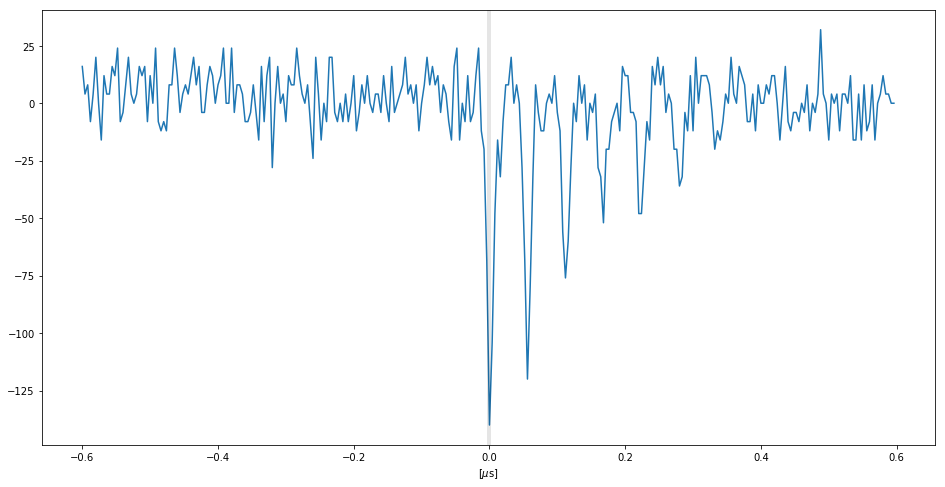

In [29]:
peakID = 120
width = 150
start, stop = peakLocs[peakID]-width, peakLocs[peakID]+width
y = data[start:stop]
x = np.linspace(-len(y)//2,len(y)//2-1,len(y))*attrs['x_increment']*1e6
fig, ax = plt.subplots(figsize = (16,8))
ax.plot(x,y)
ax.axvline((peakLocs[peakID]*4e-9-(start+stop)/2*4e-9)*1e6, color = 'black', alpha = 0.1, lw = 4)
ax.set_xlabel(r'[$\mu$s]')

In [30]:
peakHeights = []

with h5py.File(data_loc+fname, 'r') as f:
    for dset in tqdm(f['waveforms/']):
        data = np.empty([805306192,1], dtype = np.int16)
        attrs = dict(f['waveforms/record_0'].attrs.items())
        data = f['waveforms/'+dset].value
        peakLocs, peakInfo = find_peaks(-1*data, height = 55, distance = 200, width = 1)
        peakHeights.append(peakInfo['peak_heights']*attrs['gain']+attrs['offset'])
    peakHeights = np.concatenate(peakHeights).ravel()

In [31]:
peakheights_500Ohm_lightson = peakHeights.copy()

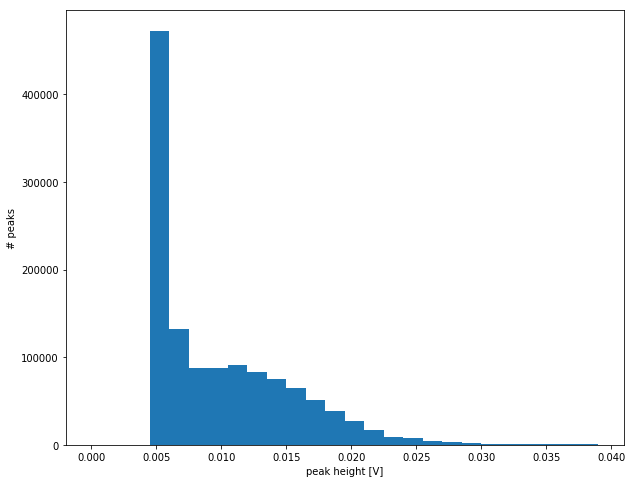

In [32]:
bins = np.arange(0,0.04,1.5e-3)
fig, ax = plt.subplots(figsize = (10,8))
hist500Ohm_on = ax.hist(peakheights_500Ohm_lightson, bins = bins);
ax.set_xlabel('peak height [V]')
ax.set_ylabel('# peaks');

In [33]:
fname = 'single_photons_lightsoff_500Ohm_ampstage1.hdf5'
peakHeights = []

with h5py.File(data_loc+fname, 'r') as f:
    for dset in tqdm(f['waveforms/']):
        data = np.empty([805306192,1], dtype = np.int16)
        attrs = dict(f['waveforms/record_0'].attrs.items())
        data = f['waveforms/'+dset].value
        peakLocs, peakInfo = find_peaks(-1*data, height = 55, distance = 200, width = 1)
        peakHeights.append(peakInfo['peak_heights']*attrs['gain']+attrs['offset'])
    peakHeights = np.concatenate(peakHeights).ravel()

In [34]:
peakheights_500Ohm_lightsoff = peakHeights.copy()

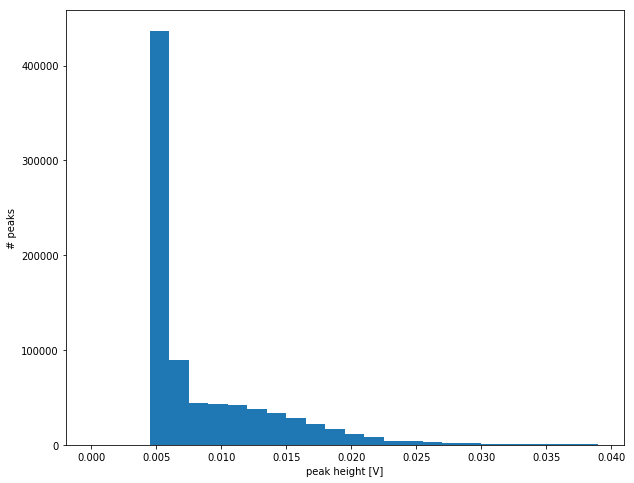

In [35]:
bins = np.arange(0,0.04,1.5e-3)
fig, ax = plt.subplots(figsize = (10,8))
hist500Ohm_off = ax.hist(peakheights_500Ohm_lightsoff, bins = bins);
ax.set_xlabel('peak height [V]')
ax.set_ylabel('# peaks');

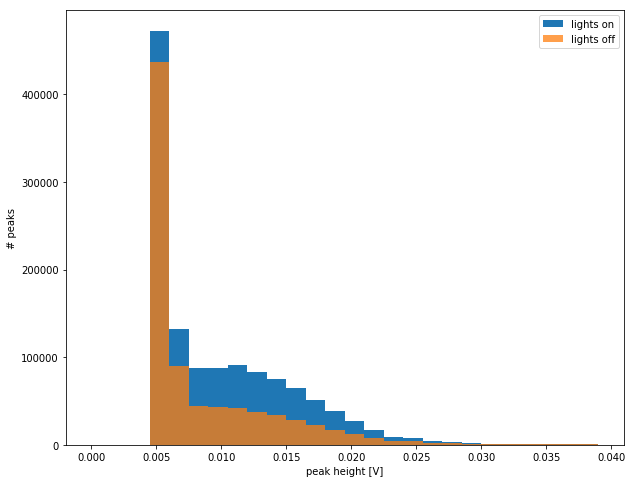

In [36]:
bins = np.arange(0,0.04,1.5e-3)

fig, ax = plt.subplots(figsize = (10,8))
ax.hist(peakheights_500Ohm_lightson, bins = bins, label = 'lights on');
ax.hist(peakheights_500Ohm_lightsoff, bins = bins, alpha = 0.75, label = 'lights off');
ax.set_xlabel('peak height [V]')
ax.set_ylabel('# peaks');
ax.legend();

Text(0.5,1,'difference')

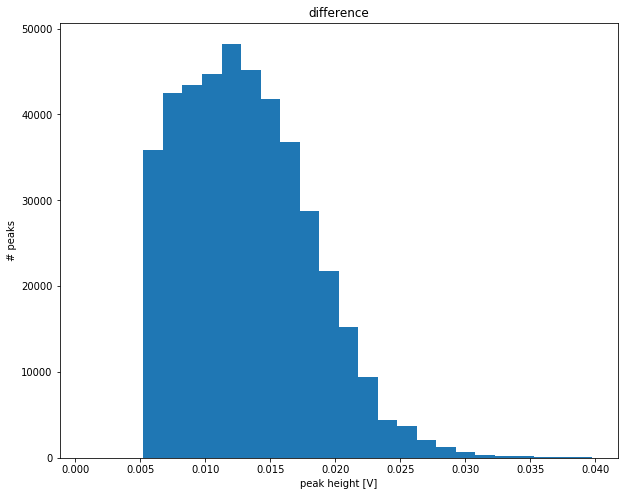

In [37]:
xx = np.diff(hist500Ohm_on[1])+hist500Ohm_on[1][:-1]
yy = hist500Ohm_on[0]-hist500Ohm_off[0]

fig, ax = plt.subplots(figsize = (10,8))
ax.bar(xx,yy, width = np.diff(xx)[0])
ax.set_xlabel('peak height [V]')
ax.set_ylabel('# peaks');
ax.set_title('difference')

mean : 12.19 mV


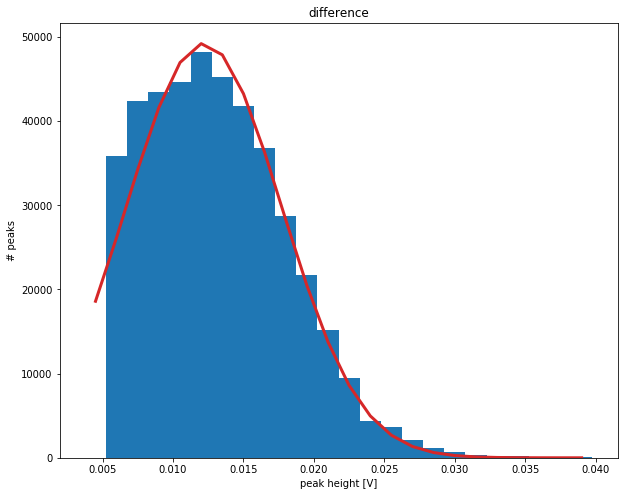

In [38]:
from scipy.optimize import curve_fit

def gaussian(x, amp, mu, sig):
    return amp*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

xx, yy = np.diff(hist500Ohm_on[1])+hist500Ohm_on[1][:-1], hist500Ohm_on[0]-hist500Ohm_off[0]
mask = xx > 0.003
xx = xx[mask]
yy = yy[mask]

fig, ax = plt.subplots(figsize = (10,8))
ax.bar(xx,yy, width = np.diff(xx)[0])
ax.set_xlabel('peak height [V]')
ax.set_ylabel('# peaks');
ax.set_title('difference')

popt, pcov = curve_fit(gaussian, xx, yy)
print('mean : {:.2f} mV'.format(popt[1]*1e3))

ax.plot(xx, gaussian(xx, *popt), 'C3', lw = 3);

In [39]:
ureg = pint.UnitRegistry()

peak = popt[1] * ureg.volt
elementary_charge = 1.6021766*1e-19 * ureg.coulomb
pmt_pulse = 9e-9 * ureg.second
load = 500 * ureg.ohm
amplifier_gain = 5


pmt_gain = (peak / ((elementary_charge/pmt_pulse)*load*amplifier_gain)).to_root_units()
print('PMT gain : {0:.2e}'.format(pmt_gain))

PMT gain : 2.74e+05 dimensionless


## 50 Ohm preamp input, SR445A@5x, PMT @1300V

In [40]:
%%time
peakHeights = []
fname = 'single_photons_lightson_50Ohm_ampstage1.hdf5'

with h5py.File(data_loc+fname, 'r') as f:
    for dset in tqdm(f['waveforms/']):
        data = np.empty([805306192,1], dtype = np.int16)
        attrs = dict(f['waveforms/record_0'].attrs.items())
        data = f['waveforms/'+dset].value
        peakLocs, peakInfo = find_peaks(-1*data, height = 40, distance = 200, width = 1)
        peakHeights.append(peakInfo['peak_heights']*attrs['gain']+attrs['offset'])
    peakHeights = np.concatenate(peakHeights).ravel()


Wall time: 10min 18s


In [41]:
peakheights_50Ohm_lightson = peakHeights.copy()

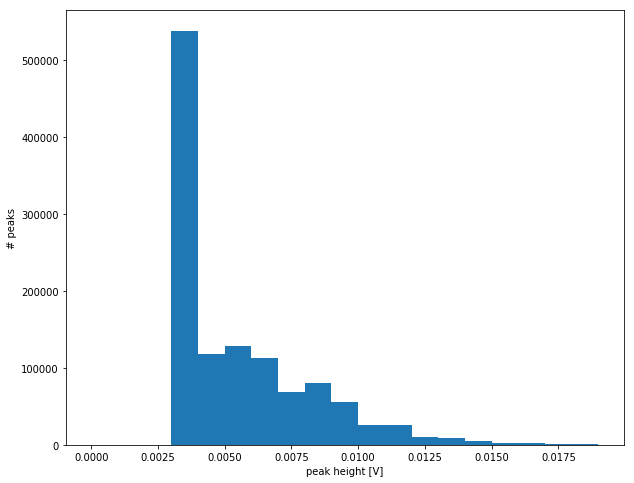

In [42]:
bins = np.arange(0,0.02,1e-3)
fig, ax = plt.subplots(figsize = (10,8))
hist50Ohm_off = ax.hist(peakheights_50Ohm_lightson, bins = bins);
ax.set_xlabel('peak height [V]')
ax.set_ylabel('# peaks');

In [43]:
%%time
peakHeights = []
fname = 'single_photons_lightsoff_50Ohm_ampstage1.hdf5'


with h5py.File(data_loc+fname, 'r') as f:
    for dset in tqdm(f['waveforms/']):
        data = np.empty([805306192,1], dtype = np.int16)
        attrs = dict(f['waveforms/record_0'].attrs.items())
        data = f['waveforms/'+dset].value
        peakLocs, peakInfo = find_peaks(-1*data, height = 40, distance = 200, width = 1)
        peakHeights.append(peakInfo['peak_heights']*attrs['gain']+attrs['offset'])
    peakHeights = np.concatenate(peakHeights).ravel()


Wall time: 9min 47s


In [44]:
peakheights_50Ohm_lightsoff = peakHeights.copy()

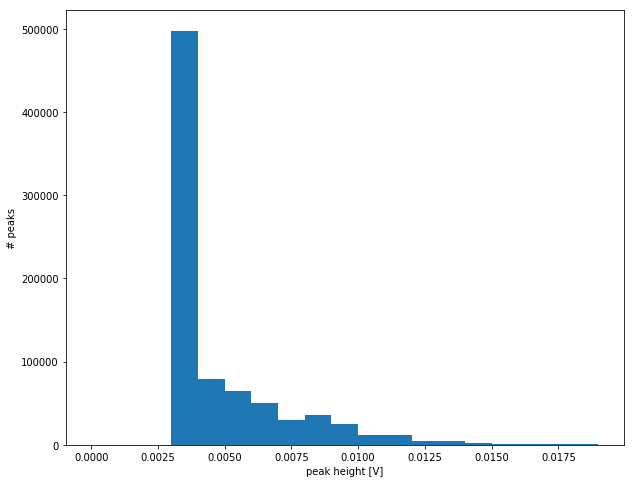

In [46]:
bins = np.arange(0,0.02,1e-3)
fig, ax = plt.subplots(figsize = (10,8))
hist50Ohm_on = ax.hist(peakheights_50Ohm_lightsoff, bins = bins);
ax.set_xlabel('peak height [V]')
ax.set_ylabel('# peaks');

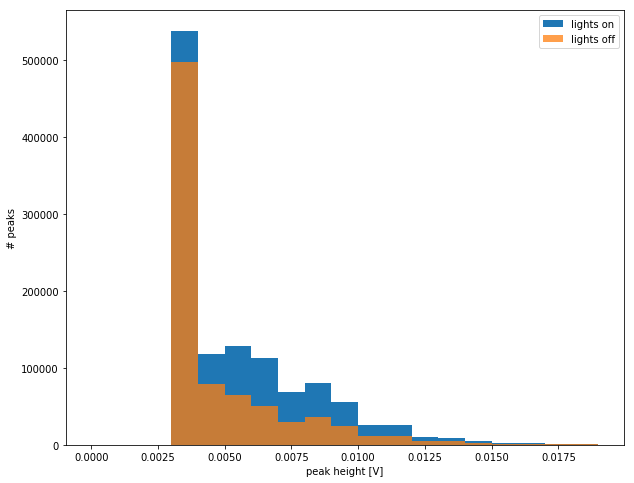

In [47]:
bins = np.arange(0,0.02,1e-3)

fig, ax = plt.subplots(figsize = (10,8))
hist50Ohm_on = ax.hist(peakheights_50Ohm_lightson, bins = bins, label = 'lights on');
hist50Ohm_off = ax.hist(peakheights_50Ohm_lightsoff, bins = bins, alpha = 0.75, label = 'lights off');
ax.set_xlabel('peak height [V]')
ax.set_ylabel('# peaks');
ax.legend();

Text(0.5,1,'difference')

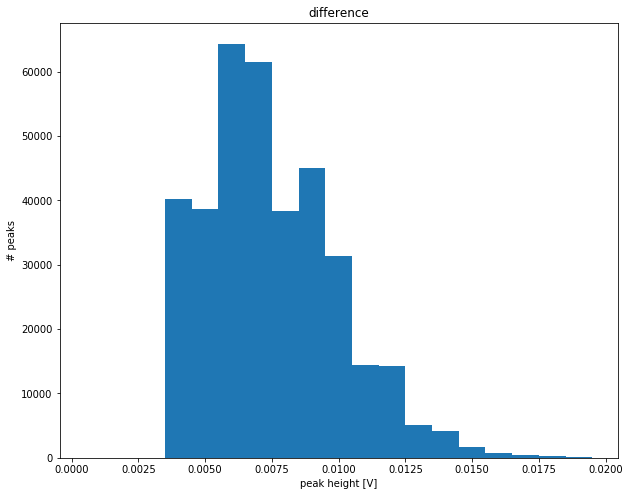

In [48]:
xx, yy = np.diff(hist50Ohm_on[1])+hist50Ohm_on[1][:-1], hist50Ohm_on[0]-hist50Ohm_off[0]

fig, ax = plt.subplots(figsize = (10,8))
ax.bar(xx,yy, width = np.diff(xx)[0])
ax.set_xlabel('peak height [V]')
ax.set_ylabel('# peaks');
ax.set_title('difference')

gaussian mean : 6.77 mV


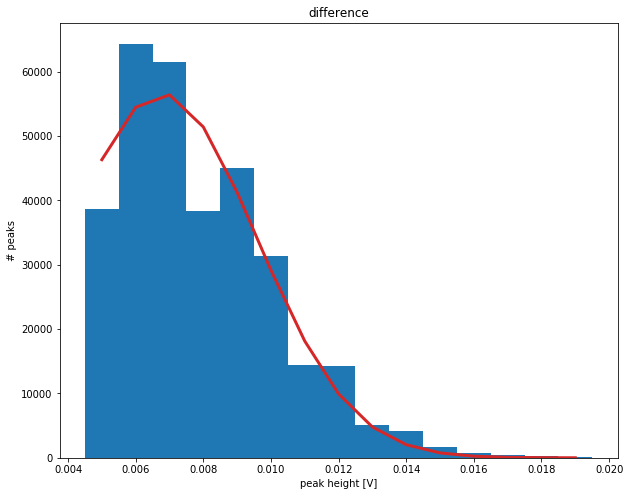

In [49]:
from scipy.optimize import curve_fit

def gaussian(x, amp, mu, sig):
    return amp*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

xx, yy = np.diff(hist50Ohm_on[1])+hist50Ohm_on[1][:-1], hist50Ohm_on[0]-hist50Ohm_off[0]
mask = xx > 0.004
xx = xx[mask]
yy = yy[mask]

fig, ax = plt.subplots(figsize = (10,8))
ax.bar(xx,yy, width = np.diff(xx)[0])
ax.set_xlabel('peak height [V]')
ax.set_ylabel('# peaks');
ax.set_title('difference')

popt, pcov = curve_fit(gaussian, xx, yy)
print('gaussian mean : {:.2f} mV'.format(popt[1]*1e3))

ax.plot(xx, gaussian(xx, *popt), 'C3', lw = 3);

In [50]:
ureg = pint.UnitRegistry()

peak = popt[1] * ureg.volt
elementary_charge = 1.6021766*1e-19 * ureg.coulomb
pmt_pulse = 9e-9 * ureg.second
load = 50 * ureg.ohm
amplifier_gain = 5


pmt_gain = (peak / ((elementary_charge/pmt_pulse)*load*amplifier_gain)).to_root_units()
print('PMT gain : {0:.2e}'.format(pmt_gain))

PMT gain : 1.52e+06 dimensionless


## 50 Ohm preamp input, SR445A@25x, PMT @1300V

In [76]:
%%time
data_loc = 'D:/PMT Single Photons/2018_12_24/'
fname = 'single_photons_lightsoff_50Ohm_ampstage12.hdf5'

data = np.empty([805306192,1], dtype = np.int16)

with h5py.File(data_loc+fname, 'r') as f:
    attrs = dict(f['waveforms/record_0'].attrs.items())
    data = f['waveforms/record_0'].value

Wall time: 8.72 s


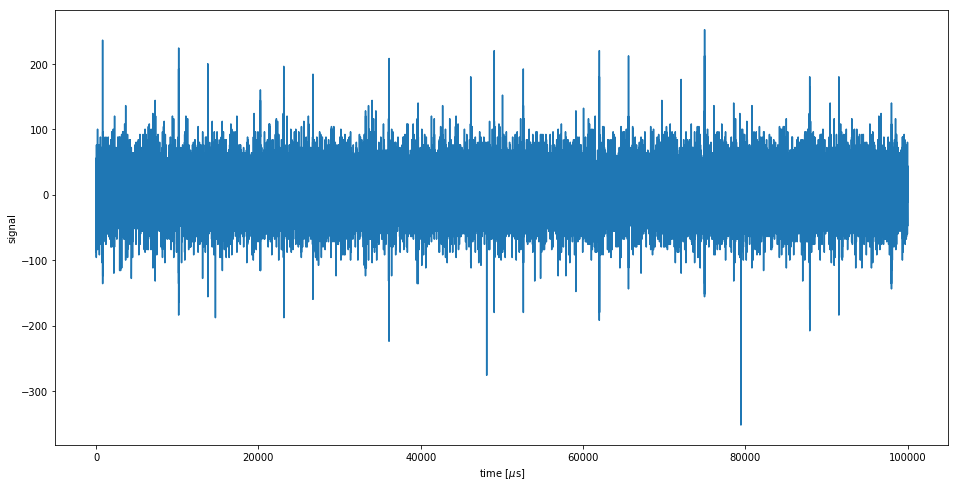

In [81]:
start, stop = 200000, 300000
y = data[start:stop]
x = np.linspace(-len(y)//2,len(y)//2-1,len(y))*attrs['x_increment']*1e6


fig, ax = plt.subplots(figsize = (16,8))
ax.plot(y)
ax.set_ylim()
ax.set_xlabel('time [$\mu$s]')
ax.set_ylabel('signal');

In [90]:
%%time
peakHeights = []
fname = 'single_photons_lightsoff_50Ohm_ampstage12.hdf5'

with h5py.File(data_loc+fname, 'r') as f:
    for dset in tqdm(f['waveforms/']):
        data = np.empty([805306192,1], dtype = np.int16)
        attrs = dict(f['waveforms/record_0'].attrs.items())
        data = f['waveforms/'+dset].value
        peakLocs, peakInfo = find_peaks(-1*data, height = 115, distance = 200, width = 1)
        peakHeights.append(peakInfo['peak_heights']*attrs['gain']+attrs['offset'])
    peakHeights = np.concatenate(peakHeights).ravel()
    
peakheights_50Ohm_amp12_lightsoff = peakHeights.copy()


Wall time: 10min 56s


In [91]:
%%time
peakHeights = []
fname = 'single_photons_lightson_50Ohm_ampstage12.hdf5'

with h5py.File(data_loc+fname, 'r') as f:
    for dset in tqdm(f['waveforms/']):
        data = np.empty([805306192,1], dtype = np.int16)
        attrs = dict(f['waveforms/record_0'].attrs.items())
        data = f['waveforms/'+dset].value
        peakLocs, peakInfo = find_peaks(-1*data, height = 115, distance = 200, width = 1)
        peakHeights.append(peakInfo['peak_heights']*attrs['gain']+attrs['offset'])
    peakHeights = np.concatenate(peakHeights).ravel()
    
peakheights_50Ohm_amp12_lightson = peakHeights.copy()


Wall time: 10min 42s


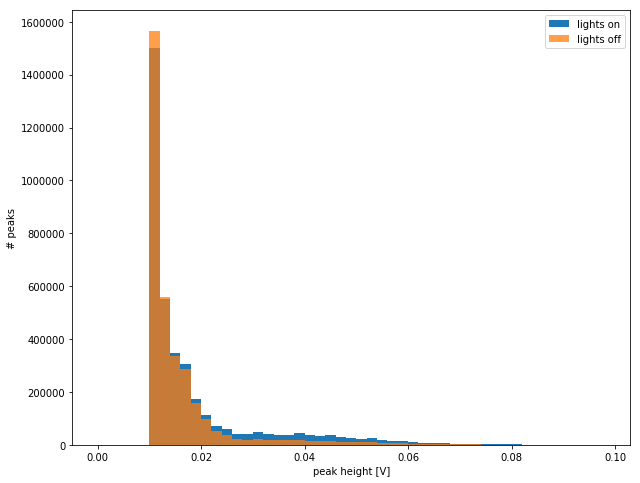

In [92]:
bins = np.arange(0,0.1,2e-3)

fig, ax = plt.subplots(figsize = (10,8))
hist50Ohm_amp12_on = ax.hist(peakheights_50Ohm_amp12_lightson, bins = bins, label = 'lights on');
hist50Ohm_amp12_off = ax.hist(peakheights_50Ohm_amp12_lightsoff, bins = bins, alpha = 0.75, label = 'lights off');
ax.set_xlabel('peak height [V]')
ax.set_ylabel('# peaks');
ax.legend();

gaussian mean : 38.04 mV


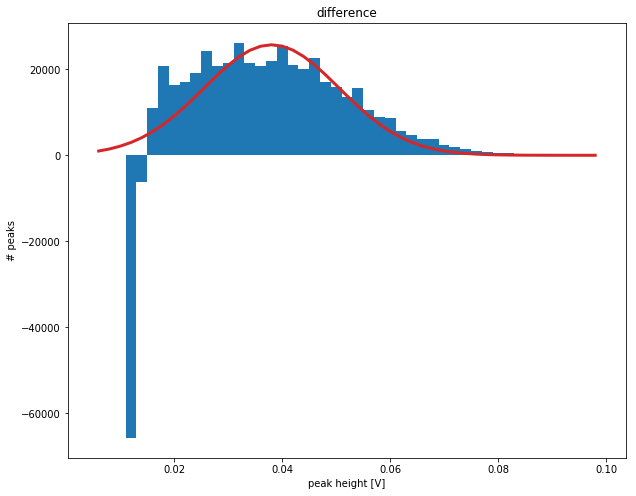

In [93]:
from scipy.optimize import curve_fit

def gaussian(x, amp, mu, sig):
    return amp*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

xx, yy = np.diff(hist50Ohm_amp12_on[1])+hist50Ohm_amp12_on[1][:-1], hist50Ohm_amp12_on[0]-hist50Ohm_amp12_off[0]
mask = xx > 0.004
xx = xx[mask]
yy = yy[mask]

fig, ax = plt.subplots(figsize = (10,8))
ax.bar(xx,yy, width = np.diff(xx)[0])
ax.set_xlabel('peak height [V]')
ax.set_ylabel('# peaks');
ax.set_title('difference')

popt, pcov = curve_fit(gaussian, xx, yy)
print('gaussian mean : {:.2f} mV'.format(popt[1]*1e3))

ax.plot(xx, gaussian(xx, *popt), 'C3', lw = 3);